In [386]:
import pandas as pd
import numpy as np
import pricey as pr
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import FinanceDataReader as fdr
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm
import statsmodels.api as sm
import itertools
from IPython.core.debugger import set_trace
import seaborn as sns
import arviz as az

from sklearnex import patch_sklearn
patch_sklearn()

# import warnings
# warnings.filterwarnings(action='ignore')

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler#, Imputer
from sklearn.cluster import KMeans, DBSCAN

%matplotlib inline

import pymc as pm
import aesara as asr

az.style.use("arviz-darkgrid")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [387]:
# import matplotlib.pyplot as plt
 
# # 한글 폰트 사용을 위해서 세팅
# from matplotlib import font_manager, rc
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)

In [388]:
univ = pd.read_excel('ticker_map.xlsx', converters={'code':str})
univ = list(univ['code']); univ

['005930',
 '005935',
 '000660',
 '006400',
 '006405',
 '051910',
 '051915',
 '005380',
 '005385',
 '035420',
 '068270',
 '000270',
 '035720',
 '105560',
 '005490',
 '055550',
 '207940',
 '012330',
 '373220',
 '028260',
 '086790',
 '033780',
 '066570',
 '066575',
 '096770',
 '316140',
 '017670',
 '034730',
 '003550',
 '030200',
 '009150',
 '259960',
 '036570',
 '323410',
 '000810',
 '009830',
 '015760',
 '032830',
 '051900',
 '010130',
 '011200',
 '003490',
 '034020',
 '003670',
 '011070',
 '018260',
 '402340',
 '028050',
 '009540',
 '010950',
 '010140',
 '352820',
 '047810',
 '097950',
 '090430',
 '034220',
 '021240',
 '000100',
 '035250',
 '086280',
 '032640',
 '251270',
 '000720',
 '011170',
 '267250',
 '004020',
 '024110',
 '161390',
 '377300',
 '010620',
 '005830',
 '011780',
 '008770',
 '383220',
 '271560',
 '006800',
 '329180',
 '071050',
 '012450',
 '018880',
 '078930',
 '016360',
 '011790',
 '001450',
 '139480',
 '010060',
 '128940',
 '138930',
 '004170',
 '030000',
 '302440',

In [389]:
_dflist = [fdr.DataReader(code, '2019-01-01', '2023-03-31')['Close'] for code in tqdm(univ)]

  0%|          | 0/147 [00:00<?, ?it/s]

In [390]:
p = pd.concat(_dflist, axis=1)
p.columns = univ
p.head()

,005930,005935,000660,006400,006405,051910,051915,005380,005385,035420,...,006650,192820,003850,105630,069500,232080,261220,132030,261240,148070
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,38750,31600,60600,210500,85800,337000,191500,114000,68600,118000,...,147500,122530,7557,19700,24086,11330,16065,9400,9610,115112
2019-01-03,37600,30800,57700,203000,83000,328000,186500,116500,69800,122000,...,139500,121059,7399,18950,23852,11068,16280,9440,9690,115150
2019-01-04,37450,30450,58300,201000,81200,330500,184000,119500,70400,125500,...,136000,123510,7452,19550,24034,11275,16925,9460,9665,114875
2019-01-07,38750,32100,58700,217000,85600,343000,190000,120500,70200,131500,...,148000,125470,7557,20650,24375,11358,17410,9425,9605,114922
2019-01-08,38100,30900,59200,218500,86100,349500,193500,119500,69900,130000,...,144000,125470,7511,21750,24220,11221,17330,9380,9645,114780


In [721]:
stock1_name, stock2_name = '005380', '005385'
# stock1_name, stock2_name = '005930', '005935'
# orig_data = logp.loc[:,[stock1_name, stock2_name]]
orig_data = logp.loc['2020-01-01':,[stock1_name, stock2_name]]
data = orig_data.diff().cumsum()
data1 = data[stock1_name].ffill().fillna(0).values
data2 = data[stock2_name].ffill().fillna(0).values

In [722]:
# p_data = p.loc[:,[stock1_name, stock2_name]]
p_data = p.loc['2020-01-01':,[stock1_name, stock2_name]]

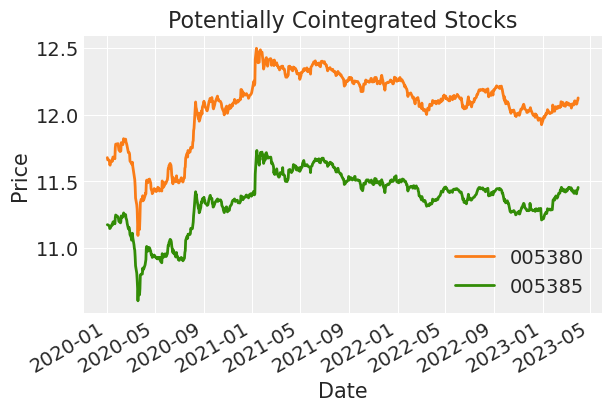

In [723]:
plt.figure(figsize = (6,4))
ax = plt.gca()
plt.title("Potentially Cointegrated Stocks")
orig_data[stock1_name].plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
orig_data[stock2_name].plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Price")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

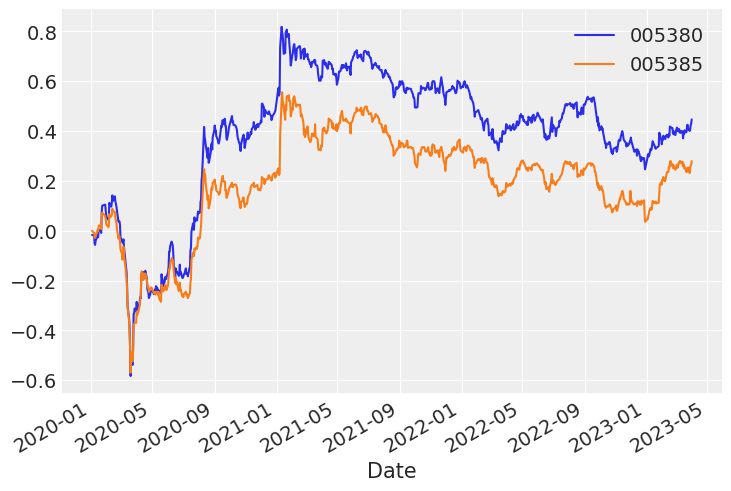

In [724]:
data[[stock1_name, stock2_name]].plot()

In [725]:
data.shape

(804, 2)

In [726]:
with pm.Model() as model:
    
    # inject external stock data
    #stock1 = asr.shared(data1)
    #stock2 = asr.shared(data2)
    stock1 = data1
    stock2 = data2
    
    # define our cointegration variables
    beta_sigma = pm.Exponential('beta_sigma', 50.)
    beta = pm.GaussianRandomWalk('beta', sigma=beta_sigma, shape=data1.shape[0])
    
    # with our assumptions, cointegration can be reframed as a regression problem
    stock2_regression = beta * stock1
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal('sd', sigma=.1)
    likelihood = pm.Normal('y', mu=stock2_regression, sigma=sd, observed=stock2)

with model:
    #stock1.set_value(data1)
    #stock2.set_value(data2)
    #trace = pm.sample(2000,tune=1000,cores=4)
    idata = pm.sample(chains=2, cores=4)

C:\ProgramData\Anaconda3\envs\pymc_env\Lib\site-packages\pymc\distributions\timeseries.py:301: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_sigma, beta, sd]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


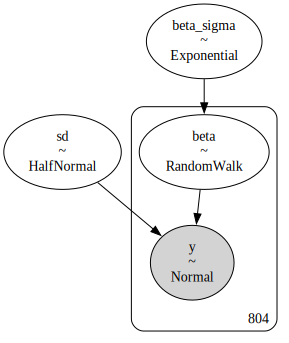

In [541]:
pm.model_to_graphviz(model)

In [727]:
rolling_beta = idata.posterior['beta'].T.mean(axis=1)[:,0]#.mean(axis=1)

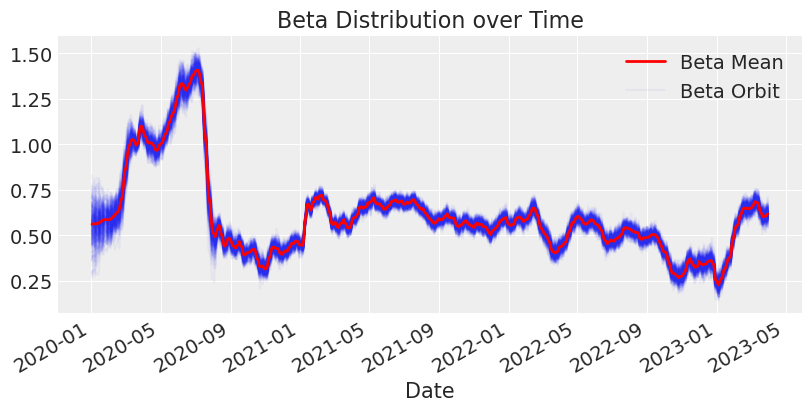

In [728]:
plt.figure(figsize = (8,4))
ax = plt.gca()
plt.title("Beta Distribution over Time")
pd.Series(rolling_beta,index=orig_data.index).plot(ax=ax,color='r',zorder=1e6,linewidth=2)

for orbit in idata.posterior['beta'].sel(draw=slice(0,200))[0]:
    pd.Series(orbit,index=orig_data.index).plot(ax=ax,color=sns.color_palette()[0],alpha=0.05)
    

plt.legend(['Beta Mean','Beta Orbit'])
plt.show()

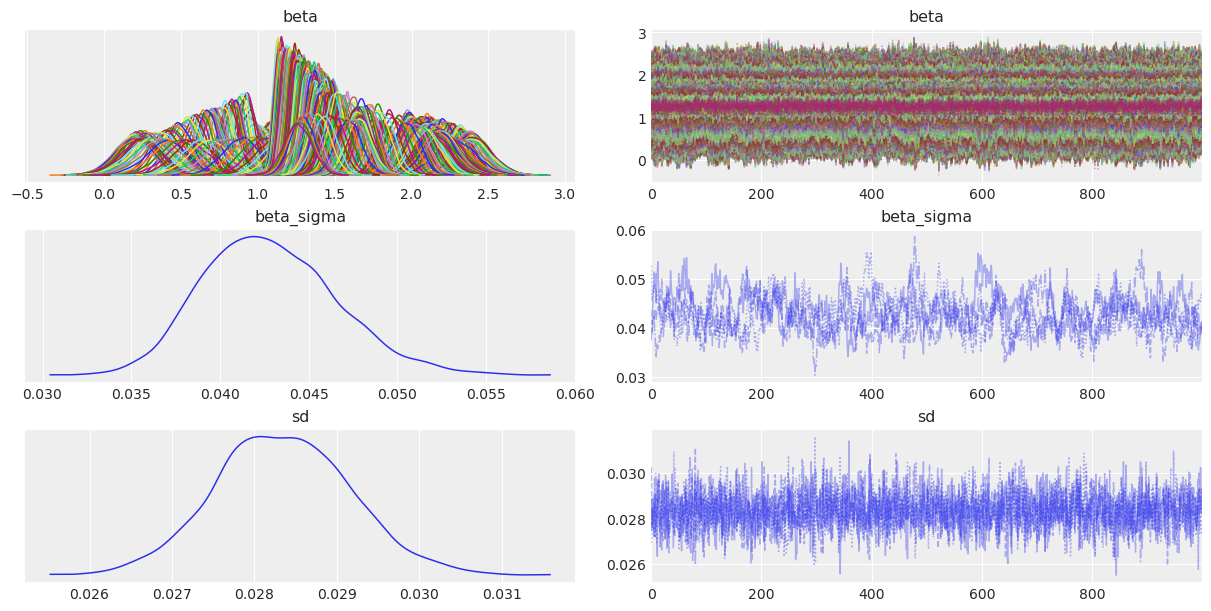

In [270]:
az.plot_trace(idata, combined=True);

In [729]:
def getStrategyPortfolioWeights(rolling_beta, stock_name1, stock_name2, data, smoothing_window=15):
    data1 = data[stock_name1].ffill().fillna(0).values
    data2 = data[stock_name2].ffill().fillna(0).values

    # initial signal rebalance
    #fixed_beta = float(rolling_beta[smoothing_window])
    #signal = fixed_beta*data1 - data2
    #smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
    #d_smoothed_signal = smoothed_signal.diff()
    trading = "not"
    trading_start = 0
    leverage = 0*data.copy()
    
    for i in range(smoothing_window, data1.shape[0]):
        leverage.iloc[i,:] = leverage.iloc[i-1,:]

        if trading=="not":
            # dynamically rebalance the signal when not trading
            fixed_beta = float(rolling_beta[i])
            signal = fixed_beta*data1 - data2
            smoothed_signal = pd.Series(signal).rolling(smoothing_window).mean()
            d_smoothed_signal = smoothed_signal.diff()

            if smoothed_signal[i] > 0 and d_smoothed_signal[i] < 0:
                leverage.iloc[i,0] = -fixed_beta / (abs(fixed_beta)+1)
                leverage.iloc[i,1] = 1 / (abs(fixed_beta)+1)
                trading = "short"
                trading_start = smoothed_signal[i]
                

#             elif smoothed_signal[i] < 0 and d_smoothed_signal[i] > 0:
#                 #fixed_beta = float(rolling_beta[i])
#                 leverage.iloc[i,0] = fixed_beta / (abs(fixed_beta)+1)
#                 leverage.iloc[i,1] = -1 / (abs(fixed_beta)+1)
#                 trading = "long"
#                 trading_start = smoothed_signal[i]

            else:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0

        elif trading=="long":
            # a failed trade
            if smoothed_signal[i] < trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] > 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

        elif trading=="short":
            # a failed trade
            if smoothed_signal[i] > trading_start:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"

            # a successful trade
            if smoothed_signal[i] < 0:
                leverage.iloc[i,0] = 0
                leverage.iloc[i,1] = 0
                trading = "not"
                
    return leverage

In [730]:
def backtest(pricingDF, leverageDF, start_cash):
    """Backtests pricing based on some given set of leverage. Leverage works such that it happens "overnight",
    so leverage for "today" is applied to yesterday's close price. This algo can handle NaNs in pricing data
    before a stock exists, but ffill() should be used for NaNs that occur after the stock has existed, even
    if that stock ceases to exist later."""
    
    pricing = pricingDF.values
    leverage = leverageDF.values
    
    shares = np.zeros_like(pricing)
    cash = np.zeros(pricing.shape[0])
    cash[0] = start_cash
    curr_price = np.zeros(pricing.shape[1])
    curr_price_div = np.zeros(pricing.shape[1])
    
    for t in range(1, pricing.shape[0]):
        
        #set_trace()
        if np.any(leverage[t] != leverage[t-1]):
            # handle non-existent stock values
            curr_price[:] = pricing[t-1]     # you can multiply with this one
            curr_price[np.isnan(curr_price)] = 0
            trading_allowed = (curr_price!=0)
            curr_price_div[:] = curr_price    # you can divide with this one
            curr_price_div[~trading_allowed] = 1
            
            # determine new positions (warning: leverage to non-trading_allowed stocks is just lost)
            portfolio_value = (shares[t-1]*curr_price).sum()+cash[t-1]
            target_shares = trading_allowed * (portfolio_value*leverage[t]) // curr_price_div
            
            # rebalance
            shares[t] = target_shares
            cash[t] = cash[t-1] - ((shares[t]-shares[t-1])*curr_price).sum()
            
        else:
            
            # maintain positions
            shares[t] = shares[t-1]
            cash[t] = cash[t-1]
    
    returns = (shares*np.nan_to_num(pricing)).sum(axis=1)+cash
    pct_returns = (returns-start_cash) / start_cash
    
    return (
        pd.DataFrame(shares, index=pricingDF.index, columns=pricingDF.columns),
        pd.Series(cash, index=pricingDF.index),
        pd.Series(pct_returns, index=pricingDF.index)
    )

<Axes: xlabel='Date'>

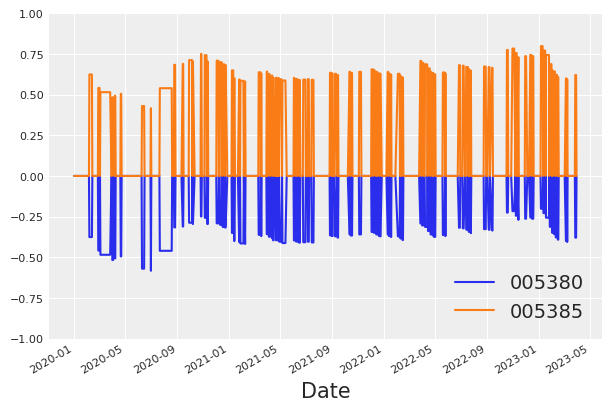

In [736]:
portfolioWeights = getStrategyPortfolioWeights(rolling_beta, stock1_name, stock2_name, data, smoothing_window=5).fillna(0)
portfolioWeights.plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

In [738]:
portfolioWeights.to_excel('weights.xlsx')
p_data.to_excel('prices.xlsx')

<Axes: xlabel='Date'>

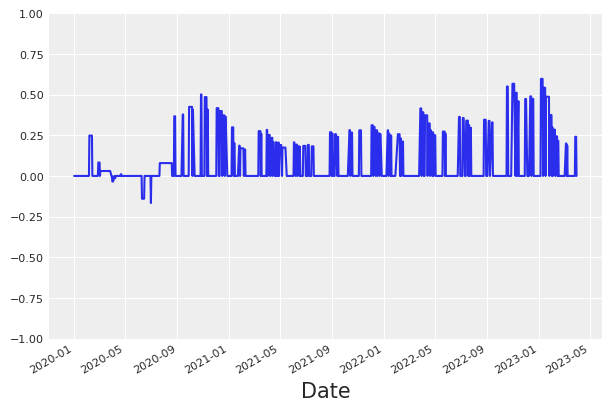

In [732]:
portfolioWeights.sum(axis=1).plot(figsize=(6,4), ylim=(-1,1), fontsize=8)

<Axes: xlabel='Date'>

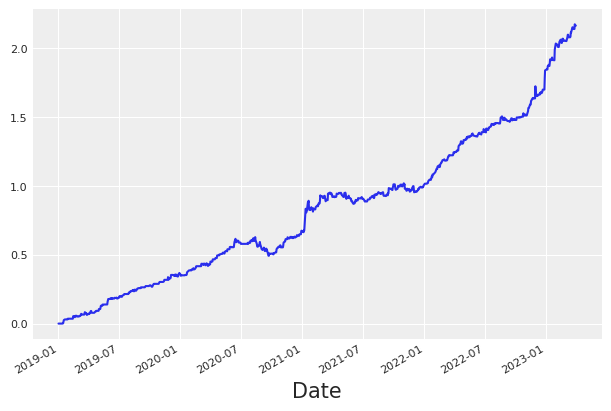

In [713]:
shares, cash, returns = backtest(p_data, portfolioWeights, 1e6)
# plt.figure(figsize=(6,4))
# ax = plt.gca()
# plt.title("Return Profile of Algorithm")
# plt.ylabel("Percent Returns")
# returns.plot(ax=ax,linewidth=3)
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
# plt.show()
returns.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

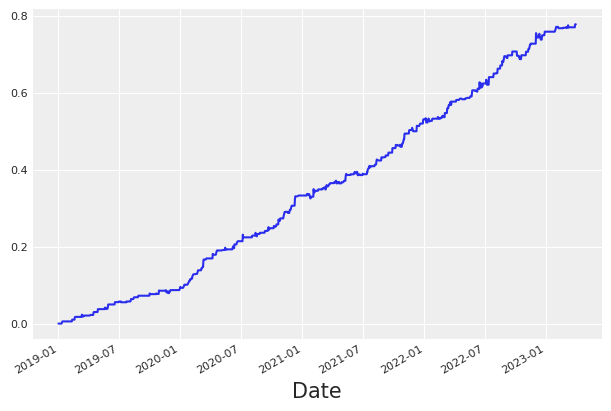

In [680]:
shares, cash, returns = backtest(p_data, portfolioWeights, 1e6)
returns.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

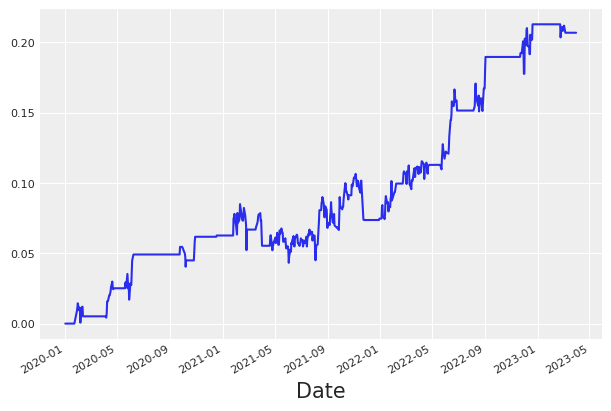

In [499]:
shares, cash, returns = backtest(p_data, portfolioWeights, 1e6)
# plt.figure(figsize=(6,4))
# ax = plt.gca()
# plt.title("Return Profile of Algorithm")
# plt.ylabel("Percent Returns")
# returns.plot(ax=ax,linewidth=3)
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
# plt.show()
returns.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

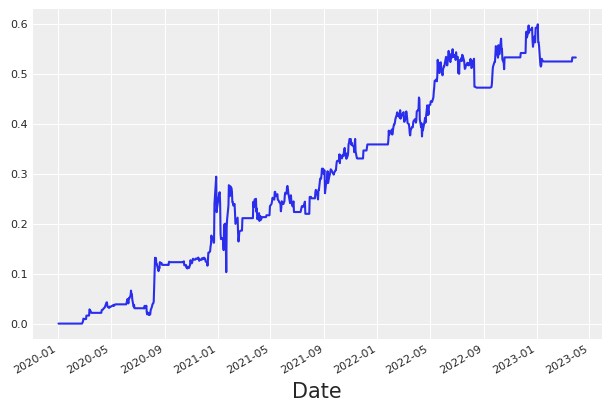

In [520]:
shares, cash, returns = backtest(p_data, portfolioWeights, 1e6)
returns.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

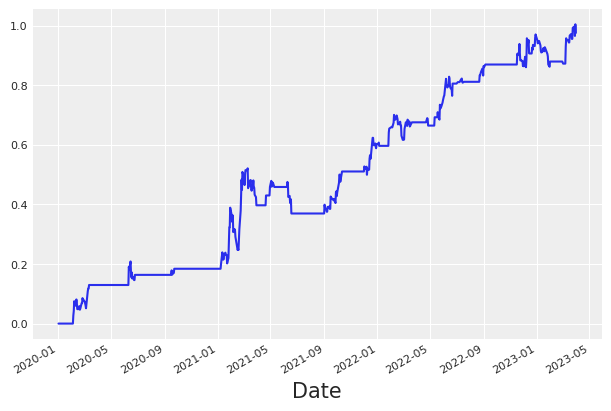

In [534]:
shares, cash, returns = backtest(p_data, portfolioWeights, 1e6)
returns.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

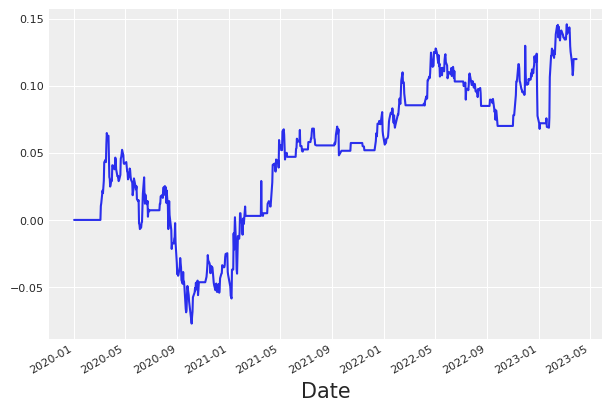

In [589]:
shares, cash, returns = backtest(p_data, portfolioWeights, 1e6)
returns.plot(figsize=(6,4), fontsize=8)

<Axes: xlabel='Date'>

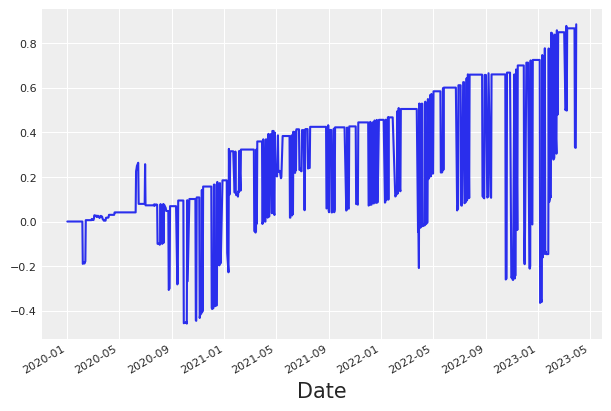

In [739]:
shares, cash, returns = backtest(p_data, portfolioWeights, 1e20)
returns.plot(figsize=(6,4), fontsize=8)